# Fine Tuning YOLO on a Custom Dataset
This notebook creates a custom dataset of randomly sized and colored circles and triangles along with an annotation file formatted for YOLO. It then uses that data to perform fine tuning on one of the pre-trained models and displays the results.

First let's import all the libraries we'll need for the notebook.

In [1]:
import cv2
import numpy as np
import os
import shutil 
from IPython.display import Image, display, Code
import matplotlib.pyplot as plt
from ultralytics import YOLO
import supervision as sv
%matplotlib inline

## Create the Dataset
Create a dataset of randomly sized and colored circles and triangles.

In [2]:
# Specify a root location for the dataset
DATA_DIR = "./datasets"

# Specify the hight and width of the images in the dataset (640 is the default YOLO size)
(IMG_WIDTH, IMG_HEIGHT) = (640, 640)

In [3]:
def delete_dirs(dirs=[]):
    """Deletes a list of directories

    Args:
        dirs (list, optional): The directories to delete. Defaults to [].
    """

    for dir in dirs:
        if os.path.exists(dir):
            shutil.rmtree(dir) 

# Delete folders generated during previous training cycles
delete_dirs(['runs/detect', f'{DATA_DIR}/test', f'{DATA_DIR}/train', f'{DATA_DIR}/val'])

In [4]:
def get_yolo_annotations(x1, y1, x2, y2, image_width, image_height):
    """Convert bounding box annotations to YOLO annotations that are resilient to image resizing.

    Args:
        x1 (int): The pixel coordinate for the left hand side of the bounding box
        y1 (int): The pixel coordinate for the top of the bounding box
        x2 (int): The pixel coordinate for the right hand side of the bounding box
        y2 (int): The pixel coordinate for the bottom of the bounding box
        image_width (int): The width of the image
        image_height (int): The height of the image

    Returns:
        center_x (float): The distance of the bounding box's center from the left side of the image. Expressed in the range of 0.0 to 1.0.
        center_y (float): The distance of the bounding box's center from the top of the image. Expressed in the range of 0.0 to 1.0.
        width (float):    The percentage of the image's width that the bounding box occupies. Expressed in the range of 0.0 to 1.0.
        height (float):   The percentage of the image's height that the bounding box occupies. Expressed in the range of 0.0 to 1.0.
    """

    center_x = (x2+x1)/2/image_width
    center_y = (y2+y1)/2/image_height
    width    = (x2-x1)/image_width
    height   = (y2-y1)/image_height
    
    return center_x, center_y, width, height

In [5]:
def write_yolo_annotations(x1, y1, x2, y2, image_width, image_height, class_id, label_file):
    """Convert the bounding box annotations to YOLO format and write to a file.

    Args:
        x1 (int): The pixel coordinate for the left hand side of the bounding box
        y1 (int): The pixel coordinate for the top of the bounding box
        x2 (int): The pixel coordinate for the right hand side of the bounding box
        y2 (int): The pixel coordinate for the bottom of the bounding box
        image_width (int): The width of the image
        image_height (int): The height of the image
        class_id (int): A unique integer associated with the class
        label_file (string): The file location to write the annotations
    """
    
    # Get YOLO annotations
    center_x, center_y, width, height = get_yolo_annotations(x1, y1, x2, y2, image_width, image_height)

    # Make sure values are reasonable
    if center_x > 0 and center_y > 0 and width > 0 and height > 0 and \
       center_x <= 1 and center_y <= 1 and width <= 1 and height <= 1:
        
        # Write the annotations
        f = open(label_file, 'a')
        f.write('{} {} {} {} {}\n'.format(class_id, center_x, center_y, width, height))
        f.close()
    else:
        print(f"At least a portion of the class is outside the image boundary ({center_x}, {center_y}, {width}, {height})")

In [6]:
def draw_random_circle(img):
    """Draws a randomly sized and colored circle on an image

    Args:
        img (array): The image to modify

    Returns:
        center_x (int): The x coordinate for the center of the circle
        center_y (int): The y coordinate for the center of the circle
        radius (int): The radius of the circle
    """
    
    radius   = np.random.randint(10, 100)
    center_x = np.random.randint(radius, IMG_WIDTH-radius)
    center_y = np.random.randint(radius, IMG_HEIGHT-radius)
    color    = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))
    
    cv2.circle(img, (center_x, center_y), radius, color, -1)

    return center_x, center_y, radius

In [7]:
def draw_random_triangle(img):
    """Draws a randomly sized and colored triangle on an image

    Args:
        img (array): The image to modify

    Returns:
        lhs (int): The x coordinate for the center of the circle
        rhs (int): The y coordinate for the center of the circle
        top (int): The radius of the circle
        bottom (int) :
    """

    # get a random point in the image at least 100 pixels from the border
    pt1 = (np.random.randint(100, IMG_WIDTH-100), np.random.randint(100, IMG_HEIGHT-100))
    # get a second point 50 to 100 pixels from the first point 
    pt2 = (pt1[0]+np.random.randint(50, 100), pt1[1]+np.random.randint(50, 100))
    # get a third point 50 to 100 pixels from the first point
    pt3 = (pt1[0]-np.random.randint(50, 100), pt1[1]+np.random.randint(50, 100))

    triangle = np.array( [pt1, pt2, pt3] )

    color = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))
    
    cv2.drawContours(img, [triangle], 0, color, -1)

    x_vals = [x[0] for x in triangle]
    y_vals = [x[1] for x in triangle]

    lhs = np.min(x_vals)
    rhs = np.max(x_vals)
    top = np.min(y_vals)
    bottom = np.max(y_vals)

    return lhs, rhs, top, bottom

In [8]:
CIRCLE_CLASS_ID   = 0
TRIANGLE_CLASS_ID = 1

def create_data(dir, num_images):
    """Populates a directory with a dataset

    Args:
        dir (string): The root directory of the dataset
        num_images (ing): The number of images in the dataset
    """
    
    img_dir   = os.path.join(DATA_DIR, dir, "images")
    label_dir = os.path.join(DATA_DIR, dir, "labels")
    os.makedirs(img_dir,   exist_ok=True)
    os.makedirs(label_dir, exist_ok=True)

    for i in range(num_images):
        img = np.random.randint(0, 255, (IMG_HEIGHT, IMG_WIDTH, 3), "uint8")
        img_file   = "{}/{}.jpg".format(img_dir,   i)
        label_file = "{}/{}.txt".format(label_dir, i)

        center_x, center_y, radius = draw_random_circle(img)
        write_yolo_annotations(center_x-radius, center_y-radius, center_x+radius, center_y+radius, IMG_WIDTH, IMG_HEIGHT, CIRCLE_CLASS_ID, label_file)

        x_min, x_max, y_min, y_max = draw_random_triangle(img)
        write_yolo_annotations(x_min, y_min, x_max, y_max, IMG_WIDTH, IMG_HEIGHT, TRIANGLE_CLASS_ID, label_file)

        cv2.imwrite(img_file, img)

Let's use these methods we just created to make our dataset.

In [9]:
create_data("train", 150)
create_data("test" ,  25)
create_data("val"  ,   9)

Let's print out one of our validation images and annotations to make sure everything looks good.

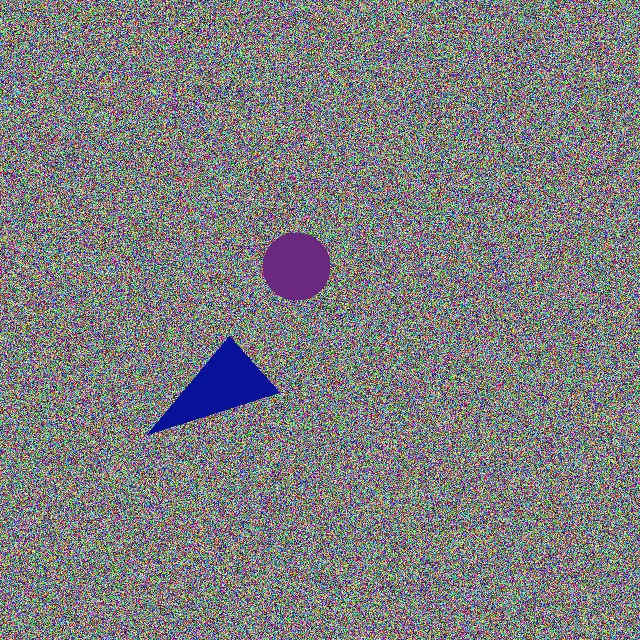

0 0.4625 0.415625 0.10625 0.10625
1 0.3328125 0.6015625 0.20625 0.153125

In [10]:
val_images_dir = 'datasets/val/images/'
val_anno_dir   = 'datasets/val/labels/'

images = [f"{val_images_dir}{image}" for image in os.listdir(val_images_dir)]
labels = [f"{val_anno_dir}{label}" for label in os.listdir(val_anno_dir)]
images.sort()
labels.sort()

# Display the image
display(Image(images[0]))

# Display the annotations
Code(filename=labels[0], language='console')

# Train the Model

In [11]:
def create_config_file(config_file):
    """Creates and writes a YOLO config file necessary for training. 

    Args:
        config_file (str): The filename.'.
    """

    if not os.path.exists(config_file):
        f = open(config_file, "x")
        f.write('''\
# Train and test folders
train: 'train'
val: 'test'

# Number of classes
nc: 2
names: ['circle', 'triangle']''')
        f.close()

config_file = 'object_v12.yaml'
create_config_file(config_file)

In [12]:
# Initialize the YOLO model and print out the supported classes
YOLO_MODEL = 'yolo12n'
model = YOLO('{}.pt'.format(YOLO_MODEL))

print(model.names.values())

dict_values(['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'])


In [13]:
# Start the training
_ = model.train(
    data = config_file,
    imgsz = 640,
    epochs = 50,
    batch = 32,
    #device='cpu',
    name = YOLO_MODEL
)

New https://pypi.org/project/ultralytics/8.3.182 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.94 🚀 Python-3.12.7 torch-2.5.1 CPU (Intel Core(TM) i9-9940X 3.30GHz)
engine/trainer: task=detect, mode=train, model=yolo12n.pt, data=object_v12.yaml, epochs=50, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolo12n, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False

E0000 00:00:1755712241.078577 2506319 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755712241.147645 2506319 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  2    180864  ultralytics.nn.modules.block.A2C2f           [128, 128, 2, True, 4]        
  7                  -1  1    295424  ultralytics

train: Scanning /home/brian/Desktop/code/Demos/yolo/datasets/train/labels... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<00:00, 910.26it/s]

train: New cache created: /home/brian/Desktop/code/Demos/yolo/datasets/train/labels.cache



val: Scanning /home/brian/Desktop/code/Demos/yolo/datasets/test/labels... 25 images, 0 backgrounds, 0 corrupt: 100%|██████████| 25/25 [00:00<00:00, 950.37it/s]

val: New cache created: /home/brian/Desktop/code/Demos/yolo/datasets/test/labels.cache


Plotting labels to runs/detect/yolo12n/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/yolo12n
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G     0.9088      3.579       1.09         78        640: 100%|██████████| 5/5 [00:28<00:00,  5.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]

                   all         25         50     0.0048       0.72       0.16      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G     0.6437      3.068     0.9355         76        640: 100%|██████████| 5/5 [00:27<00:00,  5.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]

                   all         25         50     0.0064       0.96      0.665      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G     0.6611      2.296     0.9521         62        640: 100%|██████████| 5/5 [00:26<00:00,  5.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]

                   all         25         50    0.00696          1      0.808      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G     0.6602      1.444     0.9896         77        640: 100%|██████████| 5/5 [00:26<00:00,  5.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]

                   all         25         50    0.00678       0.98      0.896       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G     0.6051      1.157     0.9567         63        640: 100%|██████████| 5/5 [00:26<00:00,  5.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]

                   all         25         50    0.00665       0.98      0.871      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G     0.6074     0.9984     0.9126         61        640: 100%|██████████| 5/5 [00:25<00:00,  5.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]

                   all         25         50    0.00655       0.98      0.893       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G       0.62      1.032     0.9476         77        640: 100%|██████████| 5/5 [00:25<00:00,  5.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]

                   all         25         50    0.00498       0.76      0.527      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G     0.5894     0.9168     0.9086         68        640: 100%|██████████| 5/5 [00:25<00:00,  5.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]

                   all         25         50    0.00238       0.36    0.00196   0.000899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      0.578     0.8973     0.9318        106        640: 100%|██████████| 5/5 [00:25<00:00,  5.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.88s/it]

                   all         25         50    0.00203        0.3    0.00187   0.000754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G     0.6213     0.9101     0.9356         72        640: 100%|██████████| 5/5 [00:25<00:00,  5.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]

                   all         25         50     0.0033       0.48    0.00296   0.000898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G     0.5653     0.8628     0.9239         62        640: 100%|██████████| 5/5 [00:24<00:00,  4.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.05s/it]

                   all         25         50      0.652       0.02     0.0532     0.0391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G     0.5378     0.8103     0.9244         66        640: 100%|██████████| 5/5 [00:24<00:00,  4.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.05s/it]

                   all         25         50          1      0.148      0.762      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G     0.5196     0.7717     0.9182         68        640: 100%|██████████| 5/5 [00:24<00:00,  4.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]

                   all         25         50       0.99      0.368      0.849      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G     0.5331     0.7588      0.923         75        640: 100%|██████████| 5/5 [00:24<00:00,  4.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.96s/it]

                   all         25         50       0.97      0.324      0.818      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G     0.5303     0.7309     0.9268         70        640: 100%|██████████| 5/5 [00:24<00:00,  4.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]

                   all         25         50      0.996      0.487      0.839      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G     0.5635     0.7527     0.9185         68        640: 100%|██████████| 5/5 [00:24<00:00,  4.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.92s/it]

                   all         25         50          1      0.539      0.944       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G     0.5178     0.7222     0.9017         62        640: 100%|██████████| 5/5 [00:24<00:00,  4.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.88s/it]

                   all         25         50          1      0.783      0.958      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G     0.4692     0.6622     0.8927         66        640: 100%|██████████| 5/5 [00:24<00:00,  4.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]

                   all         25         50      0.974       0.82       0.96      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G     0.4764     0.6438     0.8866         64        640: 100%|██████████| 5/5 [00:24<00:00,  4.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]

                   all         25         50      0.943      0.784       0.93      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G     0.4794     0.6485       0.88         72        640: 100%|██████████| 5/5 [00:24<00:00,  4.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.59s/it]

                   all         25         50      0.995      0.829       0.97      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G     0.4837      0.622     0.8886         71        640: 100%|██████████| 5/5 [00:24<00:00,  4.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]

                   all         25         50      0.978      0.838      0.975      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G     0.4831     0.6148     0.8909         59        640: 100%|██████████| 5/5 [00:24<00:00,  4.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]

                   all         25         50      0.991      0.825      0.975      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G     0.4683     0.6142     0.8849         65        640: 100%|██████████| 5/5 [00:24<00:00,  4.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]

                   all         25         50      0.993      0.949      0.974      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G     0.4527     0.5872     0.8808         75        640: 100%|██████████| 5/5 [00:24<00:00,  4.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.59s/it]

                   all         25         50       0.95       0.96       0.99       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G     0.4835     0.6036     0.8993         65        640: 100%|██████████| 5/5 [00:24<00:00,  4.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.60s/it]

                   all         25         50      0.974       0.98      0.993      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G     0.4687     0.5826     0.8937         61        640: 100%|██████████| 5/5 [00:24<00:00,  4.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]

                   all         25         50       0.97       0.92      0.969      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G     0.4928     0.6006      0.901         55        640: 100%|██████████| 5/5 [00:24<00:00,  4.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]

                   all         25         50      0.981      0.655      0.846      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G     0.4506     0.5532     0.8838         71        640: 100%|██████████| 5/5 [00:24<00:00,  4.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]

                   all         25         50      0.961      0.646      0.802      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G     0.4596     0.5538     0.8889         66        640: 100%|██████████| 5/5 [00:24<00:00,  4.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]

                   all         25         50      0.969      0.793      0.891      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G      0.406     0.5143     0.8713         59        640: 100%|██████████| 5/5 [00:24<00:00,  4.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]

                   all         25         50      0.995      0.957      0.972      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G     0.4123     0.5094      0.868         70        640: 100%|██████████| 5/5 [00:24<00:00,  4.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]

                   all         25         50      0.986      0.978       0.99      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G     0.4299      0.506     0.8863         70        640: 100%|██████████| 5/5 [00:24<00:00,  4.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.60s/it]

                   all         25         50      0.987      0.998      0.995      0.952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G     0.4169     0.5012     0.8788         82        640: 100%|██████████| 5/5 [00:24<00:00,  5.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]

                   all         25         50      0.989          1      0.995      0.941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G      0.426     0.4939     0.8747         72        640: 100%|██████████| 5/5 [00:24<00:00,  4.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]

                   all         25         50      0.991          1      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G     0.4061     0.4717     0.8679         78        640: 100%|██████████| 5/5 [00:24<00:00,  4.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

                   all         25         50      0.995          1      0.995      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G     0.3919     0.4712     0.8744         63        640: 100%|██████████| 5/5 [00:24<00:00,  4.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

                   all         25         50      0.994          1      0.995      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G     0.3727     0.4538     0.8588         78        640: 100%|██████████| 5/5 [00:24<00:00,  4.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]

                   all         25         50      0.995          1      0.995      0.979



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G     0.3586     0.4561      0.856         76        640: 100%|██████████| 5/5 [00:25<00:00,  5.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

                   all         25         50      0.996          1      0.995      0.952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G     0.3734     0.4385     0.8501         82        640: 100%|██████████| 5/5 [00:25<00:00,  5.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]

                   all         25         50      0.997          1      0.995      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G     0.3557     0.4329     0.8563         82        640: 100%|██████████| 5/5 [00:25<00:00,  5.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

                   all         25         50      0.996          1      0.995      0.969


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G     0.2703     0.4308     0.8223         44        640: 100%|██████████| 5/5 [00:24<00:00,  4.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

                   all         25         50      0.995          1      0.995      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G     0.2749     0.4414     0.8043         43        640: 100%|██████████| 5/5 [00:25<00:00,  5.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

                   all         25         50      0.997          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G     0.2754     0.4189     0.8188         41        640: 100%|██████████| 5/5 [00:25<00:00,  5.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]

                   all         25         50      0.997          1      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G     0.2676     0.4112     0.8241         42        640: 100%|██████████| 5/5 [00:25<00:00,  5.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

                   all         25         50      0.997          1      0.995      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G     0.2628     0.4183     0.8041         42        640: 100%|██████████| 5/5 [00:25<00:00,  5.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

                   all         25         50      0.996          1      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G     0.2572     0.4066     0.8097         44        640: 100%|██████████| 5/5 [00:25<00:00,  5.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

                   all         25         50      0.996          1      0.995      0.984



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G     0.2534      0.397     0.8045         44        640: 100%|██████████| 5/5 [00:25<00:00,  5.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]

                   all         25         50      0.996          1      0.995      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G     0.2338     0.3885      0.812         43        640: 100%|██████████| 5/5 [00:25<00:00,  5.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

                   all         25         50      0.997          1      0.995      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G     0.2352     0.3781     0.8035         43        640: 100%|██████████| 5/5 [00:25<00:00,  5.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

                   all         25         50      0.997          1      0.995      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G     0.2288     0.3792     0.8108         43        640: 100%|██████████| 5/5 [00:24<00:00,  4.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]

                   all         25         50      0.997          1      0.995      0.985



50 epochs completed in 0.376 hours.
Optimizer stripped from runs/detect/yolo12n/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/yolo12n/weights/best.pt, 5.5MB

Validating runs/detect/yolo12n/weights/best.pt...
Ultralytics 8.3.94 🚀 Python-3.12.7 torch-2.5.1 CPU (Intel Core(TM) i9-9940X 3.30GHz)
YOLOv12n summary (fused): 159 layers, 2,557,118 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


                   all         25         50      0.997          1      0.995      0.987
                circle         25         25      0.998          1      0.995       0.98
              triangle         25         25      0.996          1      0.995      0.995
Speed: 0.7ms preprocess, 38.0ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/yolo12n


In [14]:
# Display the classes the model supports now
print(model.names)

{0: 'circle', 1: 'triangle'}


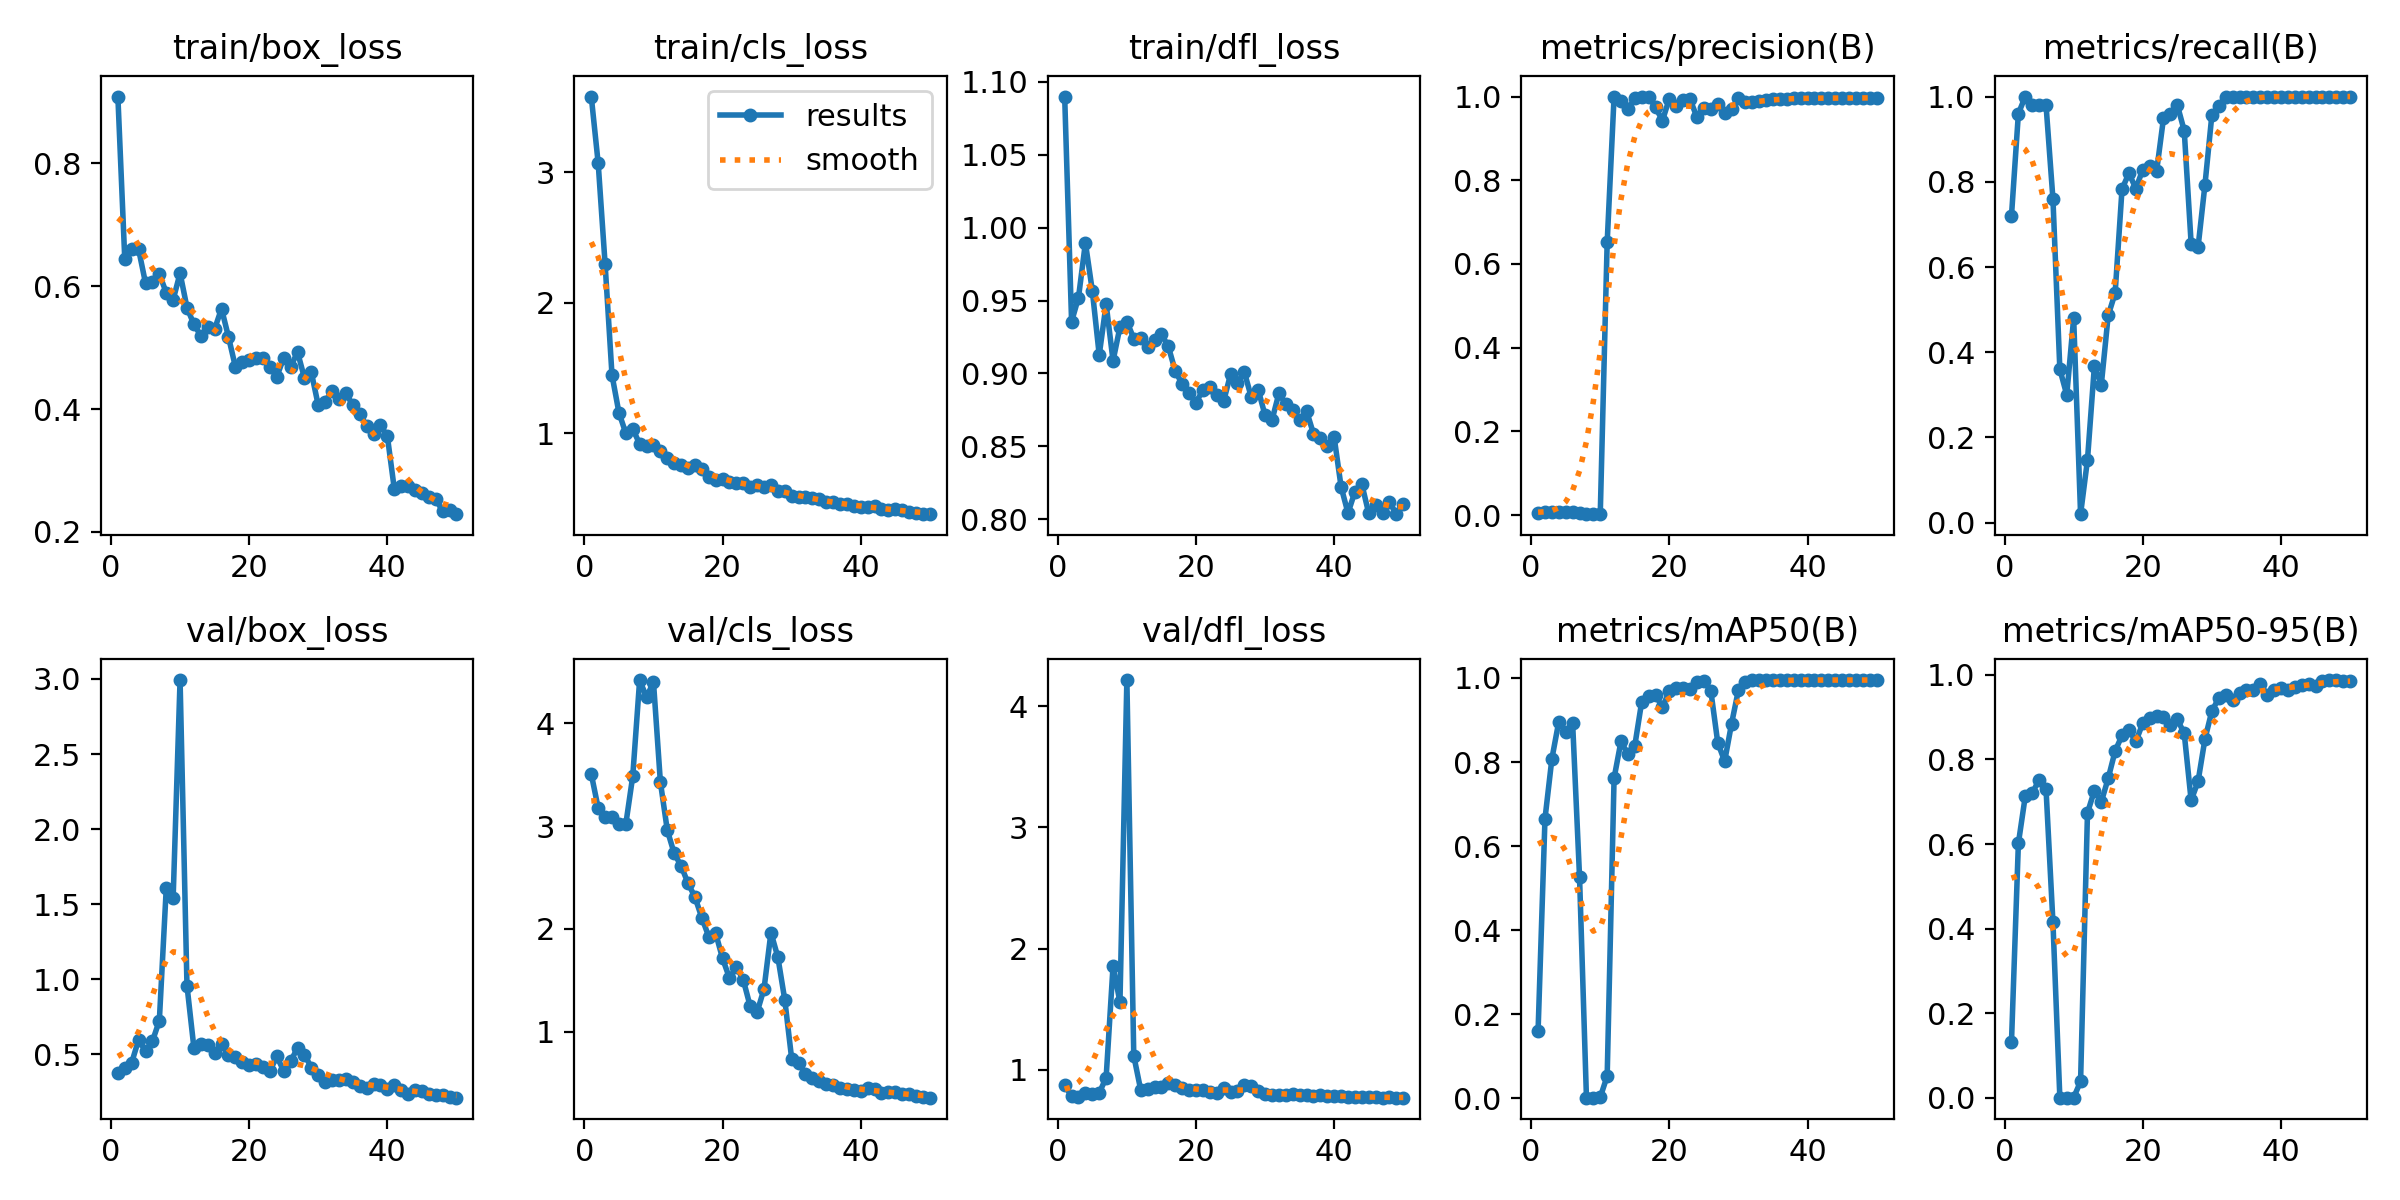

In [15]:
# Display the training characteristics
display(Image(f'runs/detect/{YOLO_MODEL}/results.png'))

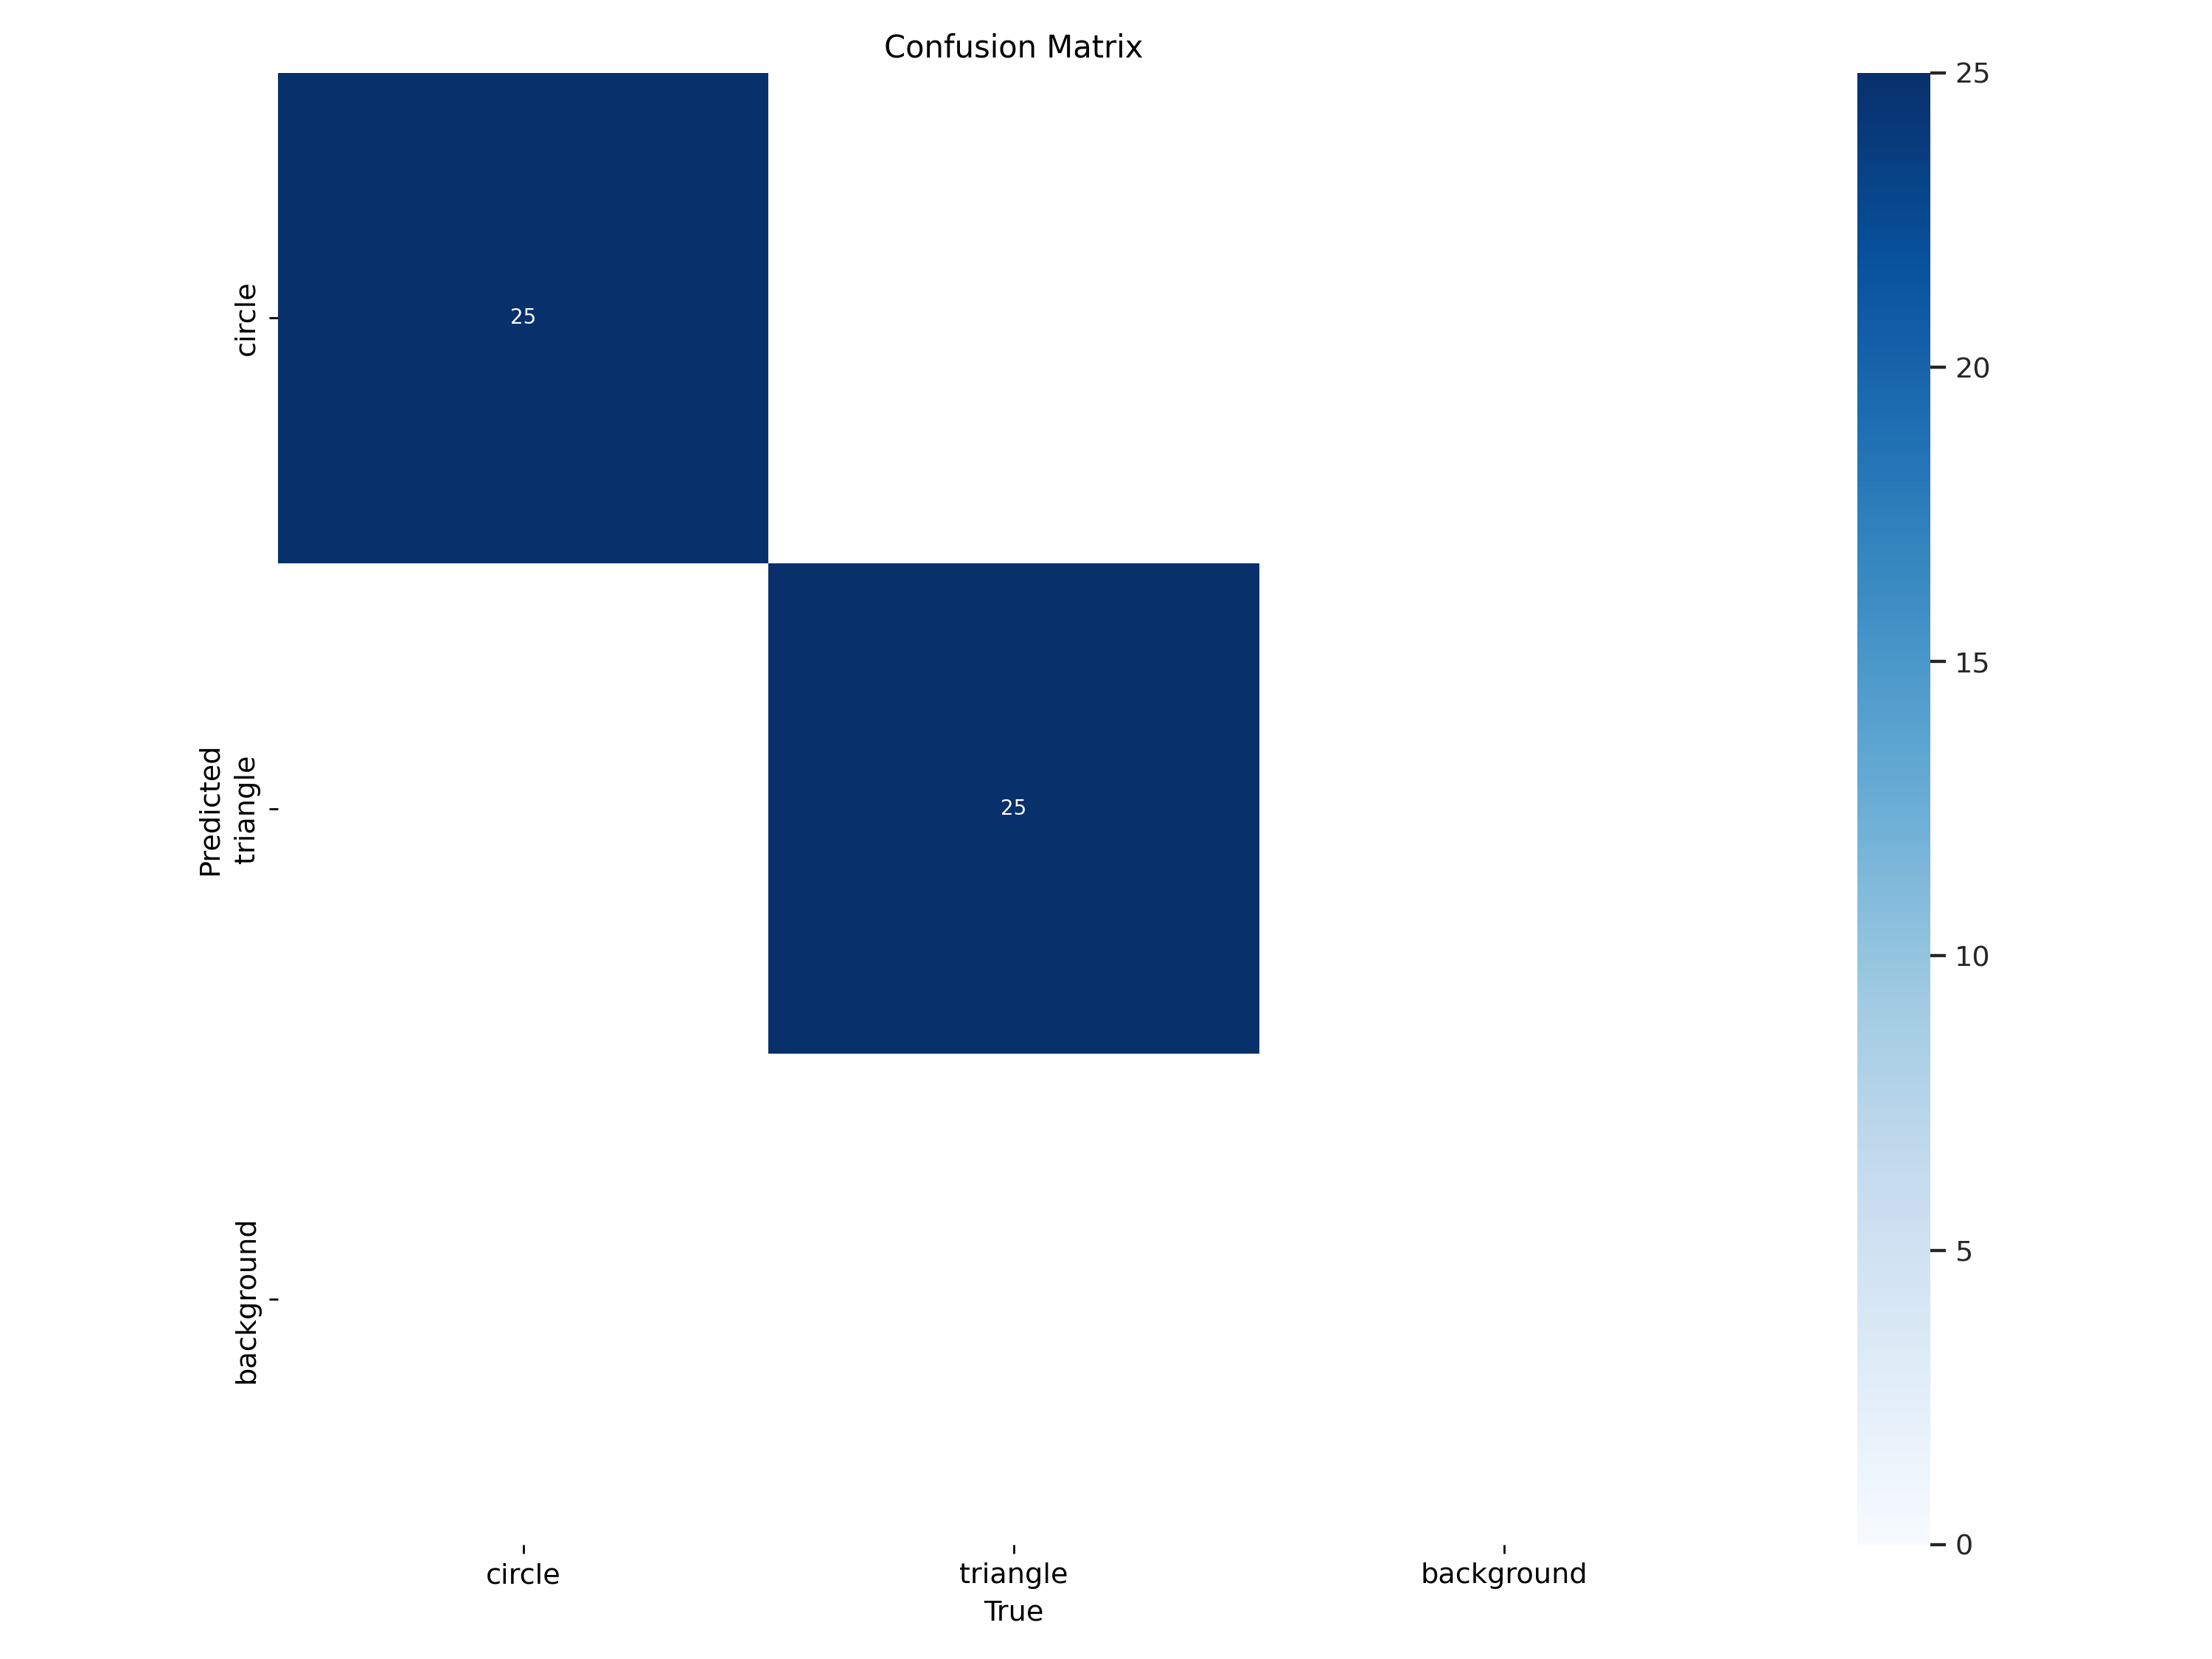

In [16]:
# Display the training characteristics
display(Image(f'runs/detect/{YOLO_MODEL}/confusion_matrix.png', width=1000, height=1000))

## Run YOLO

Let's annotate some of the model's output to see how it does.

In [17]:
# Load the best model
best_yolo_model = f'runs/detect/{YOLO_MODEL}/weights/best.pt'
model = YOLO(best_yolo_model)

# Load the paths to the validation images
val_images_dir = f'{DATA_DIR}/val/images/'
test_images = [f"{val_images_dir}{image}" for image in os.listdir(val_images_dir)]
batch_size = 64

# Create annotators for bounding box and labels
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_position=sv.Position.TOP_LEFT)

images = []

for i in range(0, len(test_images), batch_size):
    results = model.predict(test_images[i:i + batch_size])
    for result in results:
        detections = sv.Detections.from_ultralytics(result)
        img = cv2.imread(result.path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Annotate
        annotated_image = box_annotator.annotate(scene=img, detections=detections)
        annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

        images.append(annotated_image)


0: 640x640 1 circle, 1 triangle, 32.3ms
1: 640x640 1 circle, 1 triangle, 32.3ms
2: 640x640 1 circle, 1 triangle, 32.3ms
3: 640x640 1 circle, 1 triangle, 32.3ms
4: 640x640 1 circle, 1 triangle, 32.3ms
5: 640x640 2 circles, 1 triangle, 32.3ms
6: 640x640 1 circle, 1 triangle, 32.3ms
7: 640x640 1 circle, 1 triangle, 32.3ms
8: 640x640 1 circle, 1 triangle, 32.3ms
Speed: 1.5ms preprocess, 32.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


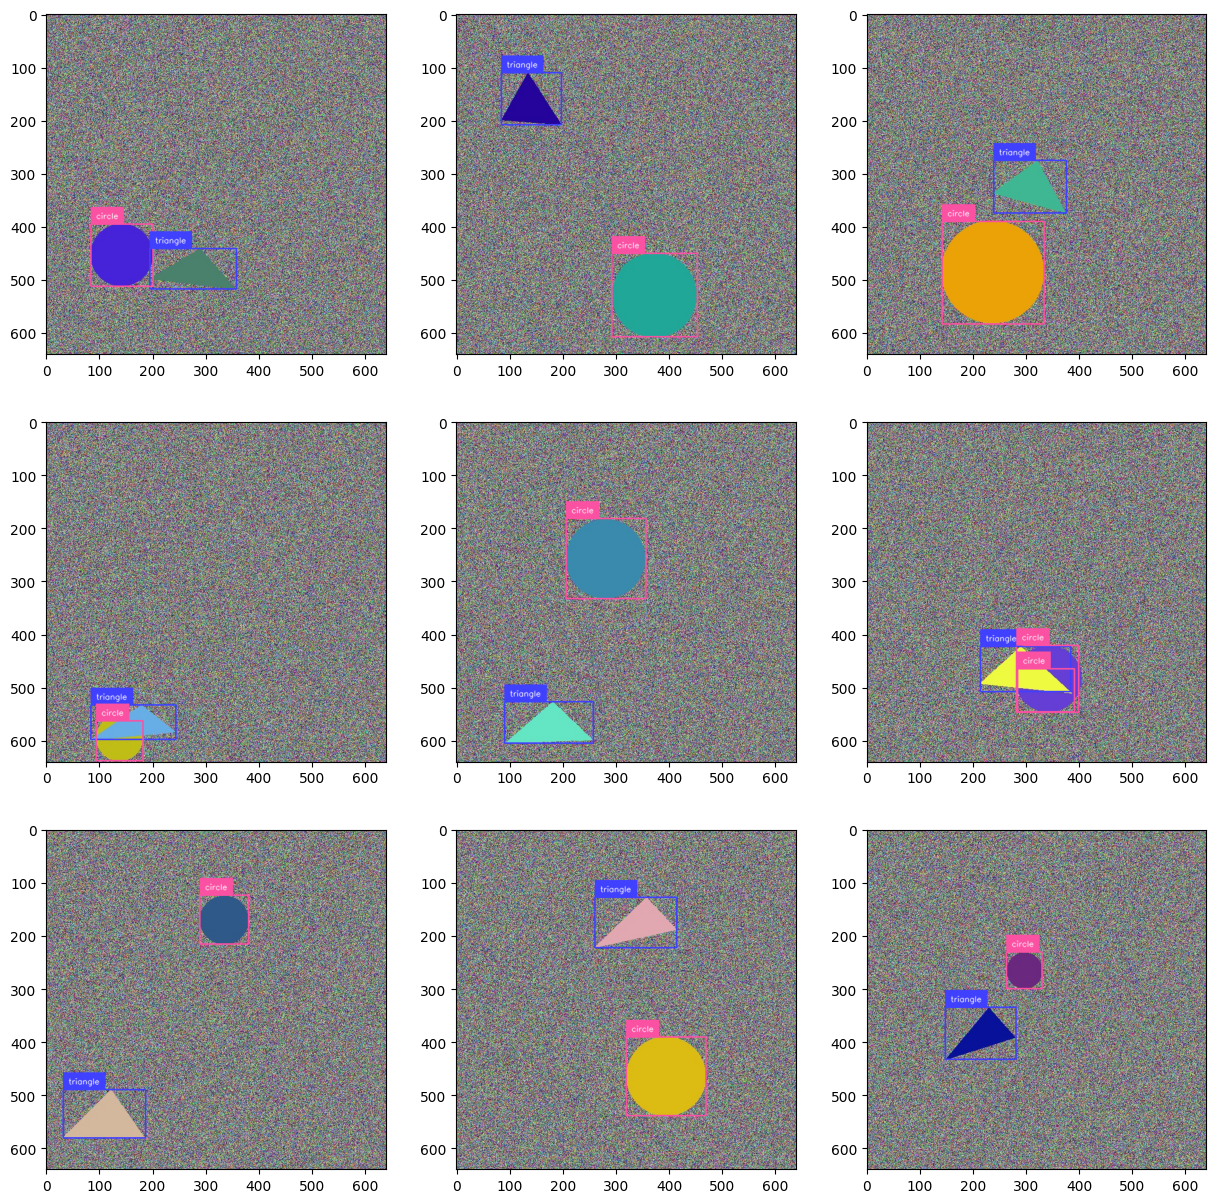

In [18]:
plt.figure(figsize=(15,15)) # specify the individual image size
#plt.figure(figsize=(15,15), dpi=1000) # specify the individual image size

for i in range(9):
    plt.subplot(3, 3, i+1)    
    plt.imshow(images[i])

plt.show()